### Dataset Information

The Chinese MNIST dataset consists of 15000 images, each representing one character from a set of 15 characters (grouped in samples, grouped in suites, with 10 samples/volunteer and 100 volunteers). 

The dataset contains the following:

* an index file named chinese_mnist.csv
* a folder with 15,000 jpg images, sized 64 x 64. 

The index file contains the following fields:  

* suite_id - each suite corresponds to a set of handwritten samples by one volunteer,so in total we have 100 suits  
* sample_id - Each sample contains a complete set of 15 characters for Chinese numbers.
* code - Code used for each chinese character with values from 1 to 15.
* value - The actual numerical value associated with the Chinese character for number.
* character - The actual Chinese character.
The files in the dataset are indexed using a file name by combining suite_id, sample_id and code. The pattern for each image is as follows:

> "input_{suite_id}_{sample_id}_{code}.jpg"

### Problem Statement
Correctly classify the chinese characters from the dataset

### Overview
In this kernel, Histogram of Oriented Gradients (HOG) is used to extract features from Chinese characters. The HOG in this context not only helps in extracting robust and critical features of the characters but also reduces the overall dimension of features from 64 x 64 = 4096 to 54 x 54 = 2916 i.e. around 28 % reduction in the number of features. Following feature extraction using HOG, the transformed data is then fed to the ANN. An accuracy of around 91-92% is obtained on the test data which can be improved using hyperparameter optimization.

### References
N. Dalal and B. Triggs, "Histograms of oriented gradients for human detection," 2005 IEEE Computer Society Conference on Computer Vision and Pattern Recognition (CVPR'05), 2005, pp. 886-893 vol. 1, doi: 10.1109/CVPR.2005.177.

Please upvote if you like my work. Thank you!

# **1. Importing Libraries**

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import sklearn
from skimage.feature import hog
import skimage.io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.sparse.linalg.eigen.arpack import eigsh as largest_eigsh
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from tensorflow.keras.layers import Dense, Input, Conv1D,MaxPooling1D, GlobalMaxPooling1D, GaussianNoise, BatchNormalization,Flatten,Dropout
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LeakyReLU
from keras.utils.np_utils import to_categorical
from tensorflow.keras.optimizers import RMSprop, Adam
from sklearn.neural_network import MLPClassifier

# **2. Data Handling and Exploration**

In [2]:
#list the contents of the input directory
os.listdir("../input/chinese-mnist")

['chinese_mnist.csv', 'data', 'chinese_mnist.tfrecords']

In [3]:
#read the csv file
data =pd.read_csv('../input/chinese-mnist/chinese_mnist.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   suite_id   15000 non-null  int64 
 1   sample_id  15000 non-null  int64 
 2   code       15000 non-null  int64 
 3   value      15000 non-null  int64 
 4   character  15000 non-null  object
dtypes: int64(4), object(1)
memory usage: 586.1+ KB


In [5]:
data.sample(1000).head() #randomly show the samples from the dataframe

,suite_id,sample_id,code,value,character
2012,10,2,12,100,百
10433,48,3,5,4,四
419,46,9,10,9,九
11076,15,6,6,5,五
6,1,6,10,9,九


In [6]:
data.groupby(["value","character"]).size()

value      character
0          零            1000
1          一            1000
2          二            1000
3          三            1000
4          四            1000
5          五            1000
6          六            1000
7          七            1000
8          八            1000
9          九            1000
10         十            1000
100        百            1000
1000       千            1000
10000      万            1000
100000000  亿            1000
dtype: int64

There are 1000 images per characters, which means that the dataset is balanced.

In [7]:
#function to identify missing data
def missing_data(data):
    null_total = data.isnull().sum().sort_values(ascending = False)
    null_percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    data_miss = pd.concat([null_total, null_percent], axis=1, keys=['Total', 'Percent'])
    return data_miss

In [8]:
missing_data(data)

,Total,Percent
suite_id,0,0.0
sample_id,0,0.0
code,0,0.0
value,0,0.0
character,0,0.0


There are no missing values in our dataset.

In [9]:
image_files = list(os.listdir("../input/chinese-mnist/data/data"))
print("Number of image files: {}".format(len(image_files)))

Number of image files: 15000


In [10]:
#function to create file name for each image in the input directory
def create_image_file_name(x):
    file_name = f"input_{x[0]}_{x[1]}_{x[2]}.jpg"
    return file_name

In [11]:
data["image_file"] = data.apply(create_image_file_name, axis=1) #append column for file names to original data

In [12]:
#function to get image size
def image_sizes(file_name):
    image = skimage.io.imread("../input/chinese-mnist/data/data/" + file_name)
    return list(image.shape)

In [13]:
image_size = np.stack(data['image_file'].apply(image_sizes))
image_size_df = pd.DataFrame(image_size,columns=['w','h'])
data = pd.concat([data,image_size_df],axis=1, sort=False)
data.head() #data after adding new columns 

,suite_id,sample_id,code,value,character,image_file,w,h
0,1,1,10,9,九,input_1_1_10.jpg,64,64
1,1,10,10,9,九,input_1_10_10.jpg,64,64
2,1,2,10,9,九,input_1_2_10.jpg,64,64
3,1,3,10,9,九,input_1_3_10.jpg,64,64
4,1,4,10,9,九,input_1_4_10.jpg,64,64


In [14]:
file_names = list(data['image_file'])
print("There are {} matching image names".format(len(set(file_names).intersection(image_files))))

There are 15000 matching image names


In [15]:
num_duplicates = data.duplicated().sum() #identify duplicates
print('There are {} duplicate rows present in the dataset'.format(num_duplicates))

There are 0 duplicate rows present in the dataset


In [16]:
#creating dataset
print("Number of suites in the dataset: {}".format(data.suite_id.nunique()))
print("Unique samples in the dataset: {}".format(sorted(data.sample_id.unique())))

Number of suites in the dataset: 100
Unique samples in the dataset: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [17]:
char_value=sorted(data['value'].unique())
print("Unique character values: {}".format(char_value))

Unique character values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100, 1000, 10000, 100000000]


In [18]:
#create a function to read images
def read_image(image_file_name):
    image = skimage.io.imread("../input/chinese-mnist/data/data/" + image_file_name)
    return image

In [19]:
# get images and labels
X = np.stack(data['image_file'].apply(read_image)) #image data
y = data['value'].to_numpy() #target_labels

In [20]:
#encoding our labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

In [21]:
np.unique(y)

array([        0,         1,         2,         3,         4,         5,
               6,         7,         8,         9,        10,       100,
            1000,     10000, 100000000])

In [22]:
np.unique(y_enc)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [23]:
#Overview of the dataset
num_pixels = X.shape[1]**2
img_dim = np.sqrt(num_pixels).astype(int)
num_classes = len(set(y))
num_samples = len(X)
print(10*"-","Overview of the Dataset",10*"-")
print("Size of each image: {} x {}".format(img_dim,img_dim))
print("Number of pixels in each image:",num_pixels)
print("Number of classes:",num_classes)
print("Total number of images:",num_samples)


---------- Overview of the Dataset ----------
Size of each image: 64 x 64
Number of pixels in each image: 4096
Number of classes: 15
Total number of images: 15000


In [24]:
#Perform normalization
X = X/255.0 #perform normalization to reduce illumination differences

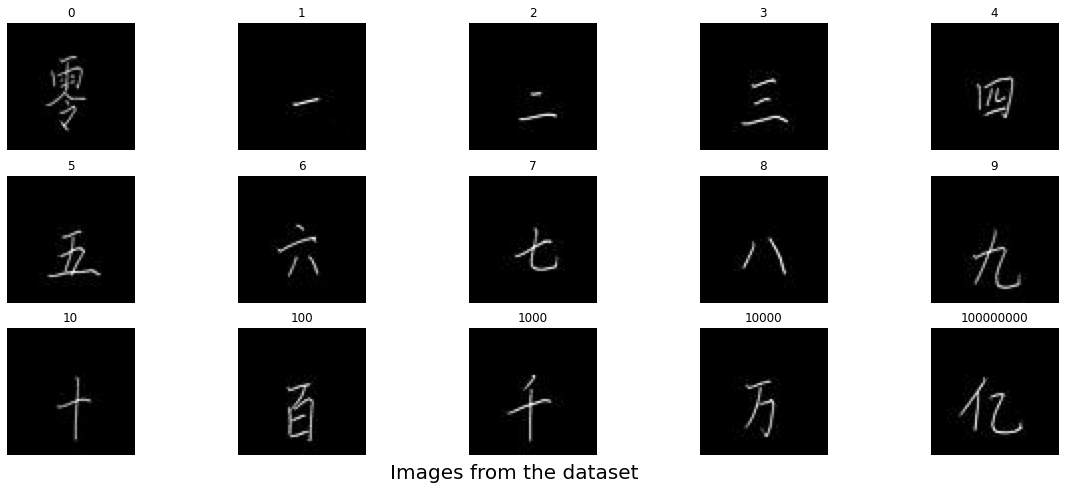

In [25]:
#Plotting images for each sign
plt.figure(figsize=(20,6))

for i,j in enumerate([6000,7000,8000,9000,10000,11000,12000,13000,14000,0,1000,2000,3000,4000,5000]):
    plt.subplot(3,5,i+1)
    plt.subplots_adjust(top = 2, bottom = 1)
    img = X[j]
    plt.imshow(img,cmap = 'gray')
    plt.title(y[j])
    plt.axis('off')
plt.suptitle('Images from the dataset',fontsize = 20)
plt.show()

# **4. HOG for feature extraction and dimension reduction**

Histogram of Oriented Gradients (HOG) is a feature descriptor that helps us finding the explicit and robust local features of an image. A feature descriptor is a representation of an image or an image patch that is a simplified version obtained by extracting useful information and throwing away extraneous information from the original image. In the HOG feature descriptor, the distribution (histograms) of directions of gradients (oriented gradients) are used as features. Gradients (x and y derivatives) of an image are useful because the magnitude of gradients is large around edges/corners which contain abrupt changes in intensity which contains lot of information regarding the object shape as compared to flatter regions. In HOG,feature extraction is performed by first dividng the complete image into smaller regions and calculating the gradients and orientation for each of these regions. This is followed by normalization over blocks of cells to reduce lighting variation since gradients of image are sensitive to overall lighting. 


In [26]:
# function to extract HOG features 
def HOG_features(data):
    sample_size = data.shape[0]
    hog_features = []
    for i in range(sample_size):
        image = data[i]
        feature = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3))
        hog_features.append(feature)
    return np.array(hog_features)

* **orientations** refers to the number of bins for the histogram.
* **pixels_per_cell** refers the patch size or size of the cell for which we create the histograms. 
* **cells_per_block** refers to the size of the block over which we normalize the histogram and is represented in number of cells included in each block.

In [27]:
#Extract hog features
X_hog = HOG_features(X)

In [28]:
dim = np.sqrt(X_hog.shape[1]).astype(int)
hog_images = X_hog.reshape(-1,dim,dim)
perc_red = np.round((1- X_hog.shape[1]/num_pixels)*100,2)

In [29]:
print('The percentage reduction in size of the features is: {} %'.format(perc_red))

The percentage reduction in size of the features is: 28.81 %


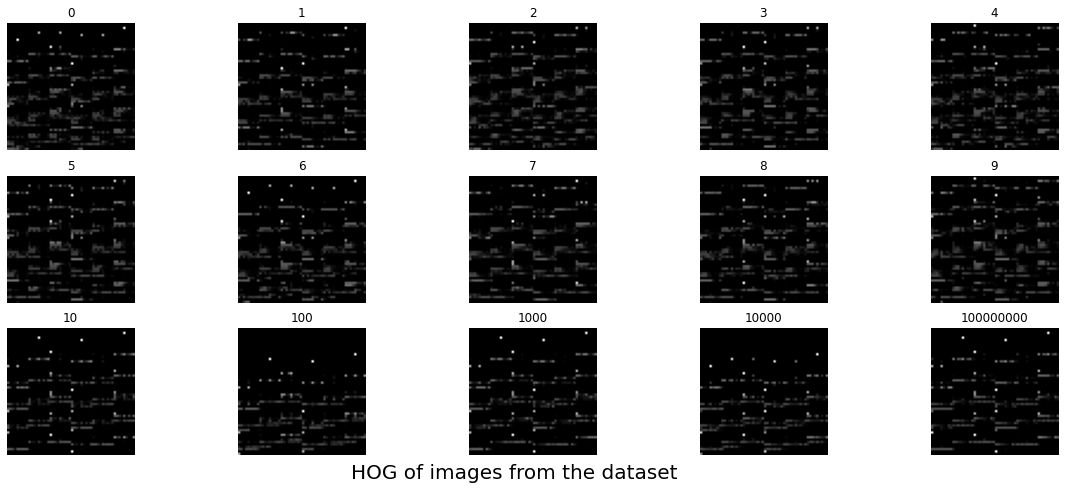

In [30]:
#some image processing to be done at a later stage.
#Plotting images for each sign
plt.figure(figsize=(20,6))

for i,j in enumerate([6000,7000,8000,9000,10000,11000,12000,13000,14000,0,1000,2000,3000,4000,5000]):
    plt.subplot(3,5,i+1)
    plt.subplots_adjust(top = 2, bottom = 1)
    plt.imshow(hog_images[i],cmap = 'gray')
    plt.title(y[j])
    plt.axis('off')
plt.suptitle('HOG of images from the dataset',fontsize = 20)
plt.show()

In [31]:
def get_data(X,y):
    #Splitting the data into training and test set
    y = to_categorical(y)
    Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size = 0.2,random_state = 2)
    #Splitting the training data into training and validation set
    Xtrain,Xval,ytrain,yval = train_test_split(Xtrain,ytrain,test_size = 0.2,random_state = 2)
    return Xtrain,Xval,Xtest,ytrain,yval,ytest

In [32]:
Xtrain,Xval,Xtest,ytrain,yval,ytest = get_data(X_hog,y_enc)

In [33]:
print("Number of samples in training set:{}".format(len(ytrain)))
print("Number of samples in validation set:{}".format(len(yval)))
print("Number of samples in testing set:{}".format(len(ytest)))

Number of samples in training set:9600
Number of samples in validation set:2400
Number of samples in testing set:3000


# **4. Performing Classification using ANN**

In [34]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  fig , ax = plt.subplots(1,2,figsize = (10,5))
  
  ax[0].plot(epochRange,history.history['accuracy'],label = 'Training Accuracy')
  ax[0].plot(epochRange,history.history['val_accuracy'],label = 'Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend()
  ax[1].plot(epochRange,history.history['loss'],label = 'Training Loss')
  ax[1].plot(epochRange,history.history['val_loss'],label = 'Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Loss')
  ax[1].legend()
  fig.tight_layout()
  plt.show()

In [35]:
np.random.seed(12)
i = Input(shape=len(Xtrain.T))
x = Dense(256, activation=LeakyReLU(0.05))(i)
x = Dropout(0.2)(x)
x = Dense(128, activation=LeakyReLU(0.05))(x)
x = Dropout(0.2)(x)
x = Dense(64, activation=LeakyReLU(0.05))(x)
x = Dropout(0.2)(x)
x = Dense(32,activation=LeakyReLU(0.05))(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(15, activation='softmax')(x)
model = Model(i, x)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2916)]            0         
_________________________________________________________________
dense (Dense)                (None, 256)               746752    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0     

In [36]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001),metrics=['accuracy']) # use categorical_crossentropy when one hot encoding is used

In [37]:
 r  = model.fit(x=Xtrain, 
          y=ytrain, 
          epochs=100,
          validation_data=(Xval, yval),
          )

Epoch 1/100
300/300 [==============================] - 3s 5ms/step - loss: 2.1249 - accuracy: 0.2793 - val_loss: 0.7651 - val_accuracy: 0.7342
Epoch 2/100
300/300 [==============================] - 1s 3ms/step - loss: 0.8512 - accuracy: 0.7046 - val_loss: 0.5545 - val_accuracy: 0.8050
Epoch 3/100
300/300 [==============================] - 1s 3ms/step - loss: 0.5956 - accuracy: 0.7869 - val_loss: 0.4272 - val_accuracy: 0.8575
Epoch 4/100
300/300 [==============================] - 1s 3ms/step - loss: 0.4596 - accuracy: 0.8414 - val_loss: 0.4738 - val_accuracy: 0.8263
Epoch 5/100
300/300 [==============================] - 1s 3ms/step - loss: 0.3935 - accuracy: 0.8665 - val_loss: 0.4024 - val_accuracy: 0.8592
Epoch 6/100
300/300 [==============================] - 1s 3ms/step - loss: 0.3696 - accuracy: 0.8715 - val_loss: 0.3278 - val_accuracy: 0.8846
Epoch 7/100
300/300 [==============================] - 1s 3ms/step - loss: 0.3149 - accuracy: 0.9003 - val_loss: 0.3892 - val_accuracy: 0.8671

In [38]:
print("Train score:", model.evaluate(Xtrain,ytrain))
print("Validation score:", model.evaluate(Xval,yval))

300/300 [==============================] - 1s 2ms/step - loss: 0.0033 - accuracy: 0.9992
Train score: [0.003271335270255804, 0.9991666674613953]
75/75 [==============================] - 0s 2ms/step - loss: 0.4747 - accuracy: 0.9125
Validation score: [0.47470396757125854, 0.9125000238418579]


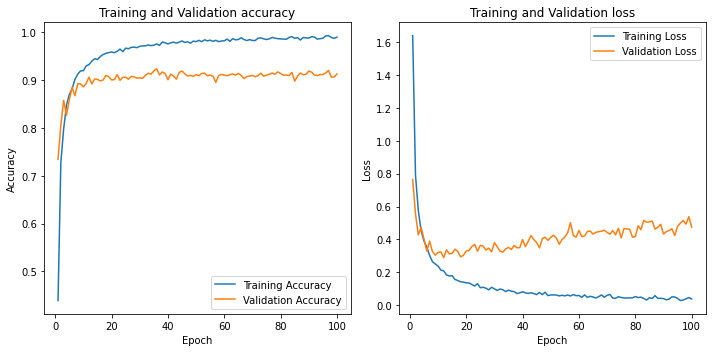

In [39]:
plotLearningCurve(r,100)

In [40]:
ypred = model.predict(Xtest)
ypred = np.argmax(ypred,axis = 1) 

ytest_labels = np.argmax(ytest,axis = -1) 

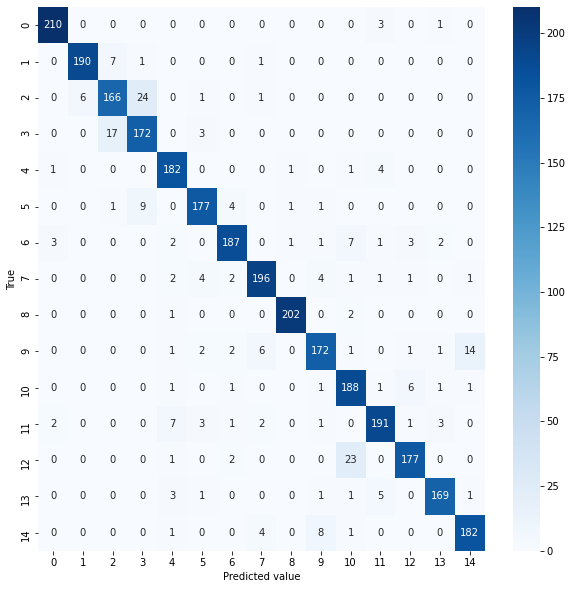

In [41]:
#plot confusion matrix
cm = confusion_matrix(ytest_labels,ypred)
plt.figure(figsize=(10,10))
sns.heatmap(cm,cmap = 'Blues',annot = True,fmt = 'g')
plt.xlabel('Predicted value')
plt.ylabel('True')
plt.show()

In [42]:
accuracy = np.round(accuracy_score(ytest_labels,ypred),4)
print("The accuracy of ANN on test set is {} %".format(accuracy*100))

The accuracy of ANN on test set is 92.03 %
